In [1]:
import matplotlib.pyplot as plt
import numpy as np
from hydra import compose, initialize
import os
os.chdir("/om2/user/ostrow/NN_delay_embeddings/nn_delay_embeddings")
from train import gen_data
from src.models import *
import torch
from omegaconf import OmegaConf
import yaml

#load the conf
path = "conf/config.yaml"
# change this path dependent on the model
# path = "/om2/user/ostrow/NN_delay_embeddings/nn_delay_embeddings/outputs/2024-04-23/10-45-10/.hydra/config.yaml"
path = "/om2/user/ostrow/NN_delay_embeddings/nn_delay_embeddings/outputs/2024-04-23/13-51-07/.hydra/config.yaml"
with open(path, 'r') as f:
    cfg = yaml.safe_load(f)
cfg = OmegaConf.create(cfg)

# with initialize(version_base="1.1", config_path=path):
#     cfg = compose(config_name="config")
cfg

/net/vast-storage/scratch/vast/fiete/ostrow/NN_delay_embeddings/nn_delay_embeddings/train.py:119: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="conf", config_name="config")


{'model': {'name': 'RNN', 'kwargs': {'input_dim': 1, 'architecture': 'VanillaRNN', 'd_model': 50, 'activation': 'relu', 'dropout': 0.1, 'seed': 10}}, 'attractor': {'name': 'Lorenz', 'driven_noise': 0.0, 'dt': 0.01, 'observed_noise': 0.0, 'dim_observed': 0, 'resample': False}, 'data': {'time': 1000, 'nsamples': 100, 'batch_size': 32}, 'train': {'optimizer': 'AdamW', 'lr': 0.005, 'weight_decay': 0.01, 'epochs': 500, 'loss': 'nn.MSELoss', 'nsteps': [1, 2], 'eval_nsteps': 100}, 'eval': {'metrics': ['compute_all_pred_stats', 'compute_dynamic_quantities', 'neighbors_comparison', 'gp_diff_asym', 'predict_hidden_dims dsa'], 'neighbors_comparison': {'n_neighbors': 100}, 'dyn_quants': {'traj_length': 1000, 'ntrajs': 10, 'rtol': 0.001, 'atol': 1e-10}, 'predict_hiddens': {'model_kwargs': {'l1_ratio': 0.5, 'alpha': 0.1, 'max_iter': 2000}}, 'dsa': {'n_delays': [100, 10], 'rank': 100, 'delay_interval': 1, 'lr': 0.005, 'iters': 1500, 'device': 'cuda'}}}

In [2]:
cfg.data.time = 2000

In [3]:
#get the dataset 
attractor, loader, data = gen_data(cfg)

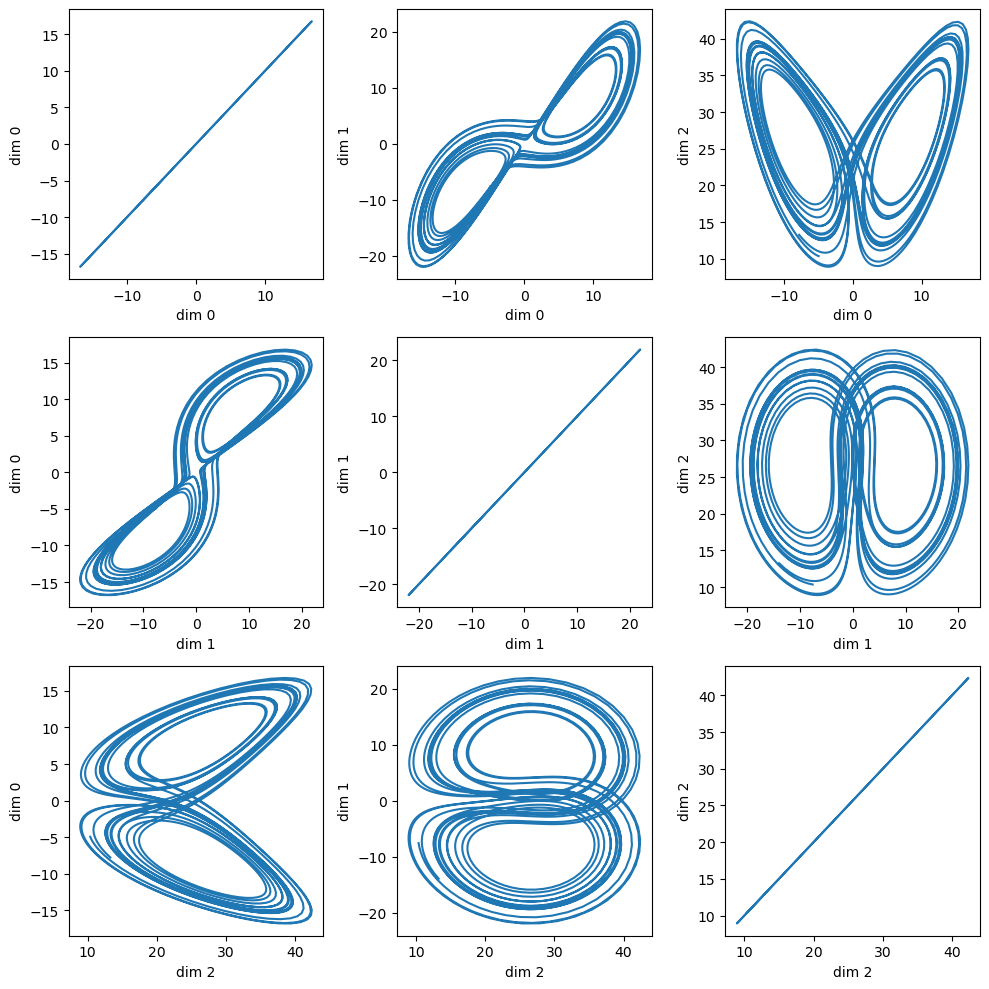

In [4]:
i = 6
fig, ax = plt.subplots(3,3,figsize=(10,10))
for j in range(3):
    for k in range(3):
        ax[j,k].plot(data[i,:,j],data[i,:,k])
        ax[j,k].set_xlabel(f"dim {j}")
        ax[j,k].set_ylabel(f"dim {k}")
    
plt.tight_layout()

In [5]:
# model = LRU(1,10,3)
model = RNN(1,100,'VanillaRNN')

In [6]:
#load the model
model_path = "/om2/user/ostrow/NN_delay_embeddings/nn_delay_embeddings/outputs/2024-04-23/13-51-07/RNN_400.pt"
model = eval(cfg.model.name)(**cfg.model.kwargs)
model.load_state_dict(torch.load(model_path))

model

RNNBase(
  (nonlinearity): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (rnn): VanillaRNN(
    (nonlinearity): ReLU()
    (x2h): Linear(in_features=1, out_features=50, bias=True)
    (h2h): Linear(in_features=50, out_features=50, bias=True)
  )
  (out): Linear(in_features=50, out_features=1, bias=True)
)

In [7]:
#test the model
x = data[:,:,cfg.attractor.dim_observed:cfg.attractor.dim_observed+1]
print(x.shape)
model.eval()
y_pred, hidden = model(x)
#cast hidden imaginary to another set of axes
hidden = hidden.detach().numpy()
hidden = hidden.real
hidden_flat = np.concatenate((hidden.real, hidden.imag), axis=2)

hidden_flat.shape,hidden.shape

torch.Size([100, 2000, 1])


((100, 2000, 100), (100, 2000, 50))

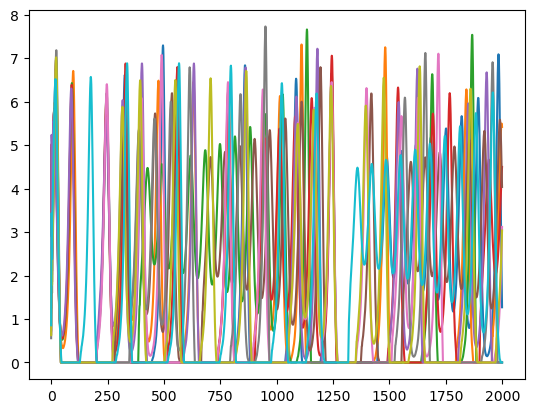

In [8]:
#visualize hidden states
plt.plot(hidden_flat[:10,:,0].T)

[0.70962328 0.28216571 0.0042525 ]


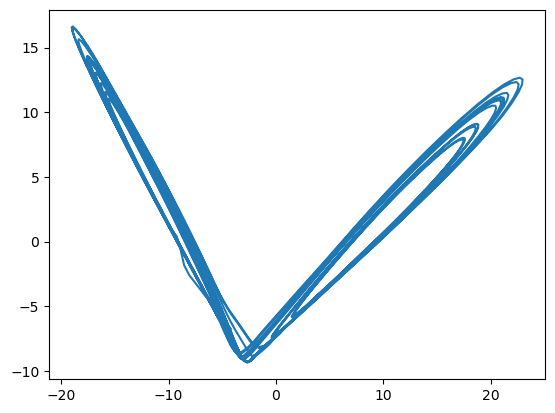

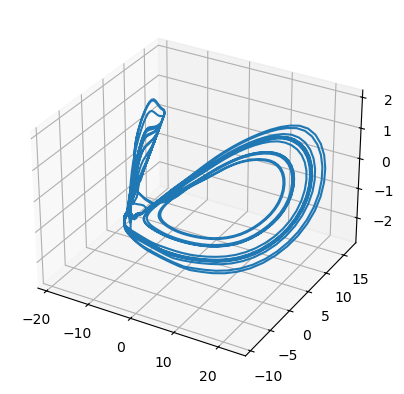

In [9]:
#do a pca on the hidden states, collaposing the first 2 dimensions and then reconsructing them
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(hidden_flat.reshape(-1,hidden_flat.shape[-1]))
hidden_pca = pca.transform(hidden_flat.reshape(-1,hidden_flat.shape[-1]))
hidden_pca = hidden_pca.reshape(hidden_flat.shape[0],hidden_flat.shape[1],3)


plt.plot(hidden_pca[i,:,0],hidden_pca[i,:,1])
print(pca.explained_variance_ratio_)

#next plot in 3d
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(hidden_pca[i,:,0],hidden_pca[i,:,1],hidden_pca[i,:,2])


In [17]:
#targeted dimensionality reduction: regress embeddings onto the true hidden states, then plot the projections
from src.metrics import predict_hidden_dims

train_score, test_score, lm = predict_hidden_dims(data,hidden_flat,cfg.attractor.dim_observed,l1_ratio=1.0,alpha=0.1,max_iter=2000)
train_score, test_score

/om2/user/ostrow/anaconda/envs/nn_delays/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.057e+03, tolerance: 1.138e+03
  model = cd_fast.enet_coordinate_descent(


(0.9287943866138247, 0.9280793582969828)

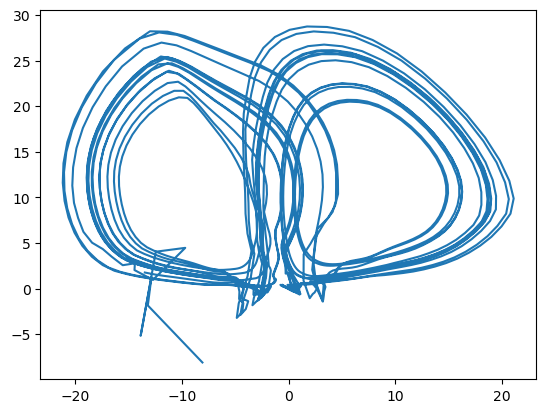

In [18]:
#project hidden onto lm.coef_ 

hidden_proj = np.dot(hidden_flat.reshape(-1,hidden_flat.shape[-1]),lm.coef_.T).reshape(hidden_flat.shape[0],hidden_flat.shape[1],lm.coef_.shape[0])
plt.plot(hidden_proj[i,:,0],hidden_proj[i,:,1])

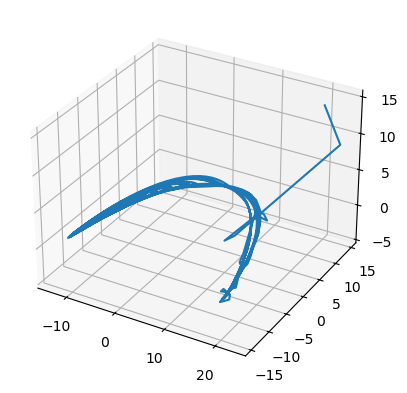

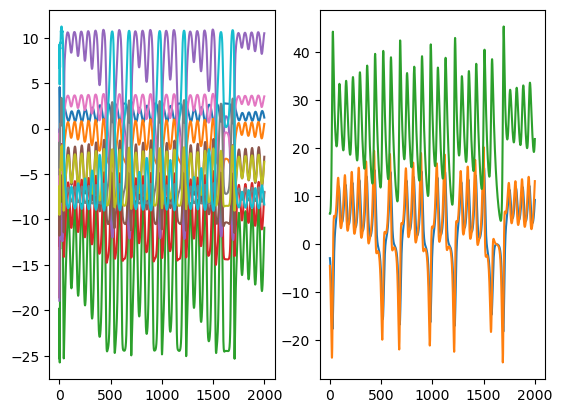

In [ ]:
#project onto model.lru.C and take the real component
hidden_proj = np.dot(hidden,model.lru.C.detach().numpy().T).real

#dimensionality reduction on this guy with pca
pca = PCA(n_components=3)
pca.fit(hidden_proj.reshape(-1,hidden_proj.shape[-1]))
hidden_pca = pca.transform(hidden_proj.reshape(-1,hidden_proj.shape[-1]))
hidden_pca = hidden_pca.reshape(hidden_proj.shape[0],hidden_proj.shape[1],3)

#3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(hidden_pca[i,:,0],hidden_pca[i,:,1],hidden_pca[i,:,2])

fig,ax = plt.subplots(1,2)

for j in range(hidden_proj.shape[-1]):
    ax[0].plot(hidden_proj[i,:,j:j+1])

#plot the actual trajectories on the other plot
for j in range(data.shape[-1]):
    ax[1].plot(data[i,:,j:j+1])

#now try projecting onto the linear layer
# linear_proj = model.mlp[0].state_dict()['weight'] #d_out x d_in
# print(linear_proj.shape)
# #project onto these dimensions now 
# hidden_real = hidden.real

# hidden_proj = np.dot(hidden_proj,linear_proj.T)
# hidden_proj.shape


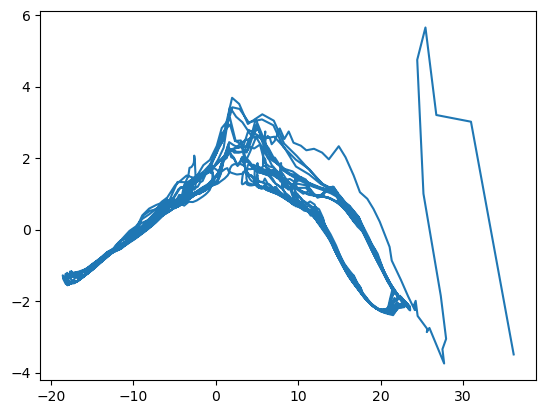

In [60]:
#try isomap visualizaation
from sklearn.manifold import Isomap
isomap = Isomap(n_components=2)

hh = hidden[:3]

isomap.fit(hh.reshape(-1,hh.shape[-1]))
hidden_isomap = isomap.transform(hh.reshape(-1,hh.shape[-1]))
hidden_isomap = hidden_isomap.reshape(hh.shape[0],hh.shape[1],2)
#plot
plt.plot(hidden_isomap[0,:,0],hidden_isomap[0,:,1])